<a href="https://colab.research.google.com/github/shivam361v/MachineLearning/blob/main/SpamDetectionModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# This is Spam fraud detection tool that is uses machine learning algorithm to detection weather an messsage is malicious or not. An genral user recieve an lot messages everyday there is an specific part belong to the spam message which can leads to the cyber attack or fraud. So, by using this we can warn our user to click on it or not.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve

Download require modules

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Data preporcessing and exploration


In [7]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [19]:
# data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v2" : "text", "v1":"label"})
data[1990:2000]

,label,text
1990,ham,HI DARLIN IVE JUST GOT BACK AND I HAD A REALLY...
1991,ham,No other Valentines huh? The proof is on your ...
1992,spam,Free tones Hope you enjoyed your new content. ...
1993,ham,Eh den sat u book e kb liao huh...
1994,ham,Have you been practising your curtsey?
1995,ham,Shall i come to get pickle
1996,ham,Lol boo I was hoping for a laugh
1997,ham,\YEH I AM DEF UP4 SOMETHING SAT
1998,ham,"Well, I have to leave for my class babe ... Yo..."
1999,ham,LMAO where's your fish memory when I need it?


In [20]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

array([[<Axes: title={'center': 'length'}>]], dtype=object)

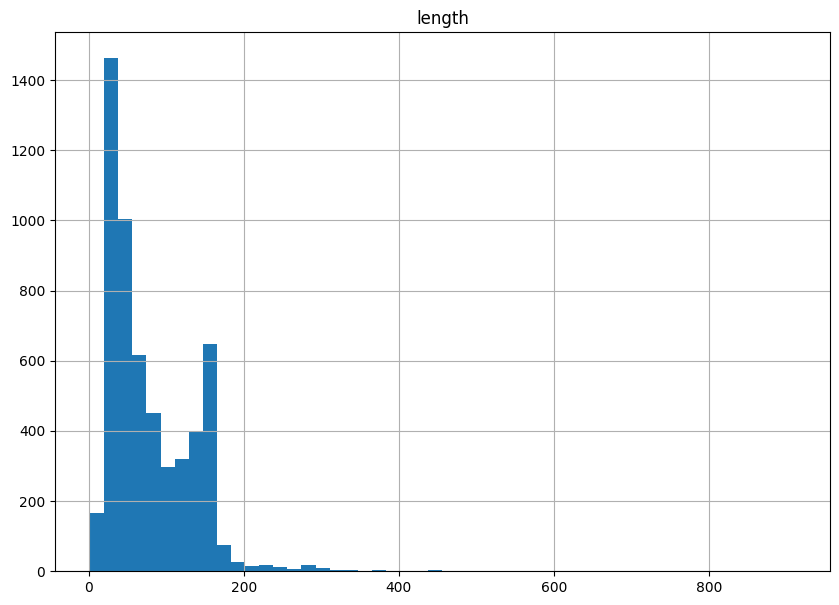

In [21]:
data['length'] = data['text'].map(lambda x: len(x))
data.hist(column='length', bins = 50, figsize = (10, 7))

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

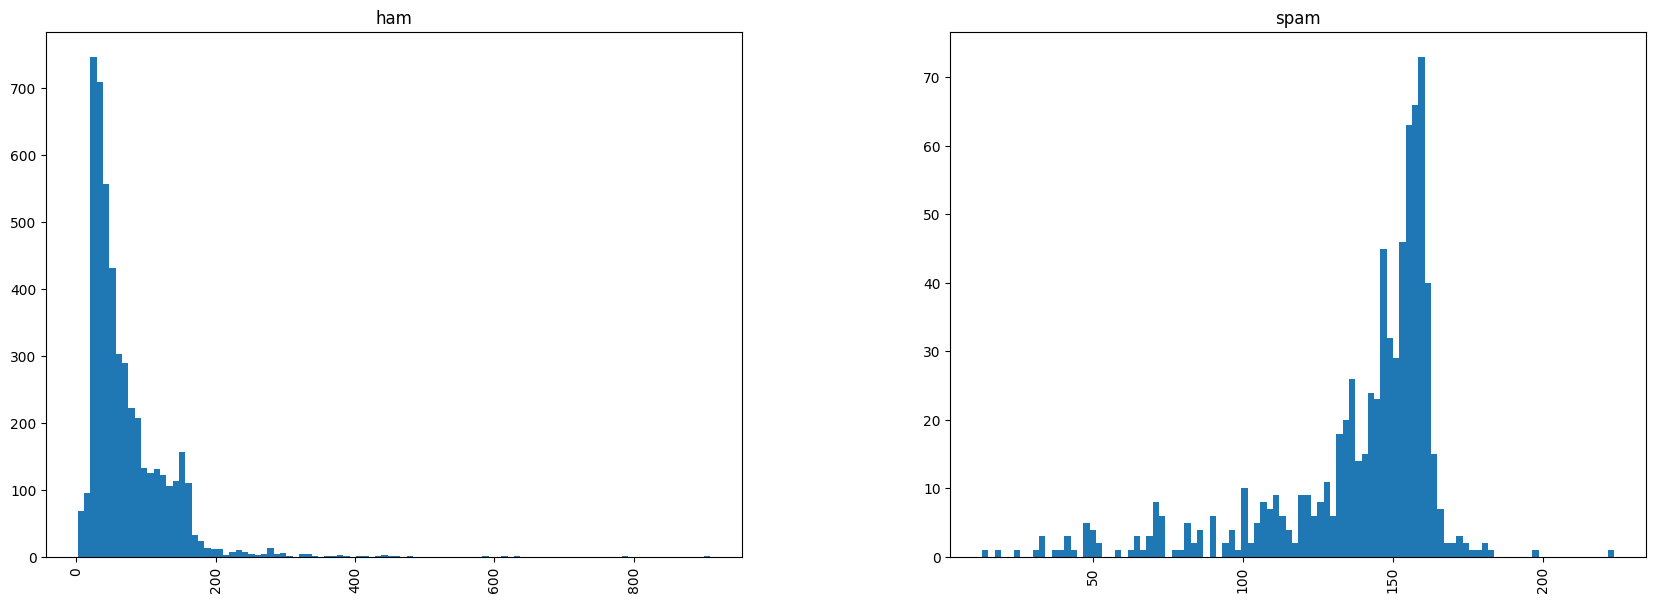

In [22]:
data.hist(column='length', by='label', bins = 100, figsize=(20, 7))

In [23]:
import warnings
warnings.filterwarnings('ignore')

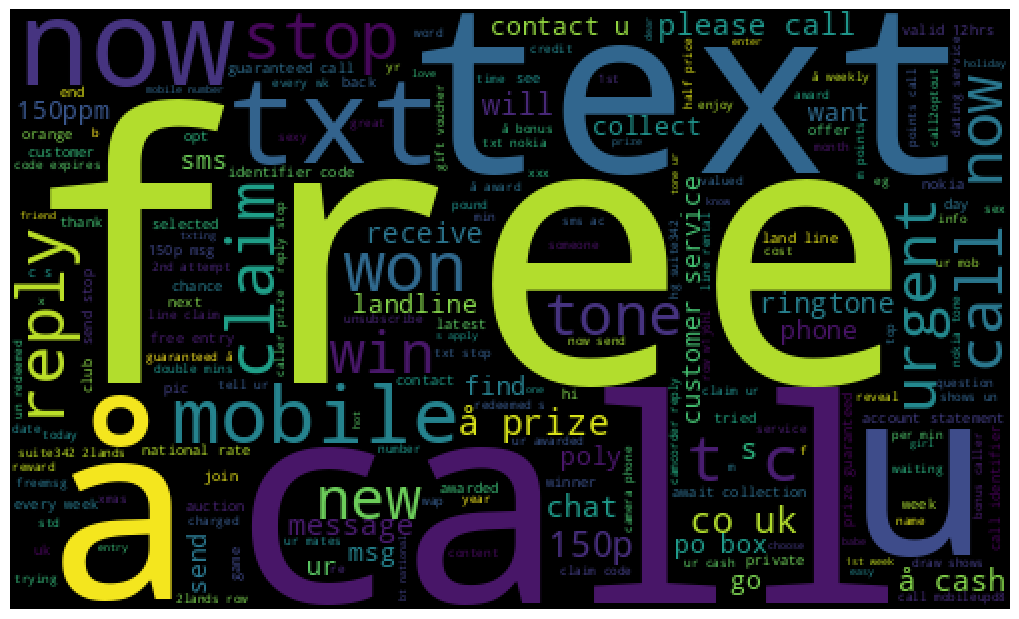

In [29]:
ham_words = ""
spam_words = ""

for val in data[data['label'] == 'spam'].text:
  text = val.lower()
  tokens = nltk.word_tokenize(text)
  for words in tokens:
    spam_words = spam_words + words + " "


for val in data[data['label'] == 'ham'].text:
  text = val.lower()
  tokens = nltk.word_tokenize(text)
  for words in tokens:
    ham_words = ham_words + words + " "

spam_wordcloud = WordCloud(width = 500, height = 300).generate(spam_words)
ham_wordcloud = WordCloud(width = 500, height = 300).generate(ham_words)

# spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
# ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

plt.figure(figsize=(10, 8), facecolor = 'w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

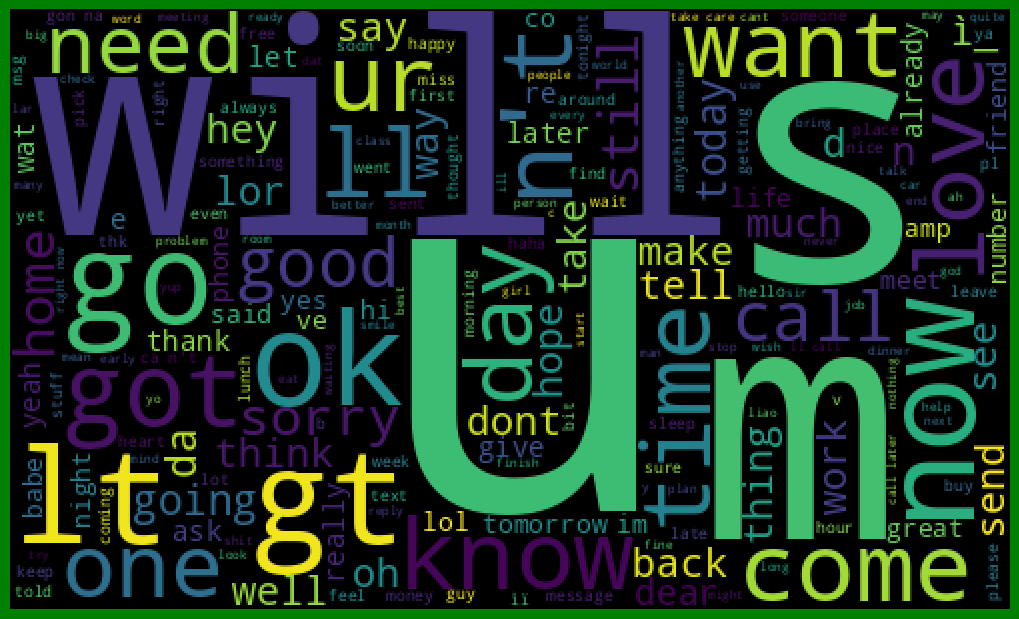

In [31]:
plt.figure(figsize = (10, 8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [32]:
data = data.replace(['ham', 'spam'], [0, 1])
data.head()

,label,text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


Text Preprocessing


In [34]:
def emoji(text):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' positiveemoji ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    text = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', text)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', text)
    return text

In [35]:
import re

def process_text_data(text):
  text = text.lower()
  text = re.sub('@[^\s]+', '', text)
  text = re.sub('((www\.[^\s]+) | (https?://[^\s]+))', ' ', text)
  text = re.sub(r"\d+", " ", str(text))
  text = re.sub('&quot;', " ", text)
  text = emoji(text)
  text = re.sub(r"\b[a-zA-Z]\b", " ", str(text))
  text = re.sub(r"[^\w\s]", " ", str(text))
  text = re.sub(r'(.)\1+', r'\1\1', text)
  text = re.sub(r"\s+", " ", str(text))
  return text

data['processed_text'] = data['text'].apply(process_text_data)
data

,label,text,length,processed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in wkly comp to win fa cup final tk...
3,0,U dun say so early hor... U c already then say...,49,dun say so early hor already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah don think he goes to usf he lives around h...
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,this is the nd time we have tried contact have...
5568,0,Will Ì_ b going to esplanade fr home?,37,will ì_ going to esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,pity was in mood for that so any other suggest...
5570,0,The guy did some bitching but I acted like i'd...,125,the guy did some bitching but acted like be in...


In [37]:
import string

def text_process(text):
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
  return " ".join(text)

data['processed_text'] = data['processed_text'].apply(text_process)
data.head()

,label,text,length,processed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis great wo...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,49,dun say early hor already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think goes usf lives around though


In [38]:
text = pd.DataFrame(data['processed_text'])
label = pd.DataFrame(data['label'])

In [40]:
from collections import Counter

total_counts = Counter()
for i in range(len(text)):
  for word in text.values[i][0].split(" "):
    total_counts[word] += 1

print("Total words in the dataset : ", len(total_counts))

Total words in the dataset :  7526


In [43]:
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:10])

['call', 'get', 'ur', 'positiveemoji', 'gt', 'lt', 'å', 'ok', 'free', 'go']


In [73]:
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i

    ### Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

# import itertools
text = text.to_frame()
    ## Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for ii, (_, text_) in enumerate(text.iterrows()):
    word_vectors[ii] = text_to_vector(text_[0])


word_vectors.shape

(1, 7526)

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape

(5572, 8672)

In [79]:
features = vectors
features

<5572x8672 sparse matrix of type '<class 'numpy.float64'>'
	with 73916 stored elements in Compressed Sparse Row format>

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state = 111)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4736, 8672)
(836, 8672)
(4736,)
(836,)


In [83]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy={1 : 4000}, random_state=42)
X_train, y_train = smote.fit_resample(X_train.astype('float'), y_train)
print("Before SMOTE:", Counter(y_train))

Before SMOTE: Counter({0: 4100, 1: 4000})


In [84]:
import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(X_train, label=y_train)
watchlist = [(d_train, 'train')]
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds = 50, verbose_eval=10)

[0]	train-error:0.02284
[10]	train-error:0.01642
[20]	train-error:0.01716
[30]	train-error:0.01642
[40]	train-error:0.01494
[50]	train-error:0.01272
[60]	train-error:0.01185
[70]	train-error:0.01074
[80]	train-error:0.00988
[90]	train-error:0.00914
[100]	train-error:0.00864
[110]	train-error:0.00802
[120]	train-error:0.00741
[130]	train-error:0.00704
[140]	train-error:0.00667
[150]	train-error:0.00605
[160]	train-error:0.00580
[170]	train-error:0.00568
[180]	train-error:0.00568
[190]	train-error:0.00543
[200]	train-error:0.00506
[210]	train-error:0.00469
[220]	train-error:0.00457
[230]	train-error:0.00432
[240]	train-error:0.00432
[250]	train-error:0.00420
[260]	train-error:0.00420
[270]	train-error:0.00407
[280]	train-error:0.00407
[290]	train-error:0.00407
[300]	train-error:0.00395
[310]	train-error:0.00370
[320]	train-error:0.00370
[330]	train-error:0.00346
[340]	train-error:0.00333
[350]	train-error:0.00333
[360]	train-error:0.00309
[370]	train-error:0.00284
[380]	train-error:0.002

In [85]:
import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(X_train, label=y_train)
watchlist = [(d_train, 'train')]
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds = 400, verbose_eval=10)

[0]	train-error:0.02284
[10]	train-error:0.01642
[20]	train-error:0.01716
[30]	train-error:0.01642
[40]	train-error:0.01494
[50]	train-error:0.01272
[60]	train-error:0.01185
[70]	train-error:0.01074
[80]	train-error:0.00988
[90]	train-error:0.00914
[100]	train-error:0.00864
[110]	train-error:0.00802
[120]	train-error:0.00741
[130]	train-error:0.00704
[140]	train-error:0.00667
[150]	train-error:0.00605
[160]	train-error:0.00580
[170]	train-error:0.00568
[180]	train-error:0.00568
[190]	train-error:0.00543
[200]	train-error:0.00506
[210]	train-error:0.00469
[220]	train-error:0.00457
[230]	train-error:0.00432
[240]	train-error:0.00432
[250]	train-error:0.00420
[260]	train-error:0.00420
[270]	train-error:0.00407
[280]	train-error:0.00407
[290]	train-error:0.00407
[300]	train-error:0.00395
[310]	train-error:0.00370
[320]	train-error:0.00370
[330]	train-error:0.00346
[340]	train-error:0.00333
[350]	train-error:0.00333
[360]	train-error:0.00309
[370]	train-error:0.00284
[380]	train-error:0.002

In [87]:
from sklearn.metrics import accuracy_score

d_test = xgb.DMatrix(X_test)
p_test = bst.predict(d_test)

npround = np.vectorize(round)
p_test_ints = npround(p_test)

accuracy = accuracy_score(y_test, p_test_ints)
print("Test Accuracy :", accuracy)

Test Accuracy : 0.9868421052631579


In [88]:
from sklearn.metrics import classification_report

print(classification_report(y_test, p_test_ints))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       725
           1       0.95      0.95      0.95       111

    accuracy                           0.99       836
   macro avg       0.97      0.97      0.97       836
weighted avg       0.99      0.99      0.99       836



In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [93]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

clfs = {'SVC' : svc, 'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

def train(clf, features, targets):
  clf.fit(features, targets)

def predict(clf, features):
  return (clf.predict(features))


In [95]:
pred_scores_word_vectors = []

for k,v in clfs.items():
  train(v, X_train, y_train)
  pred = predict(v, X_test)
  pred_scores_word_vectors.append((k, [accuracy_score(y_test, pred)]))

predictions = pd.DataFrame.from_dict(dict(pred_scores_word_vectors), orient='index', columns=['score'])
predictions

,score
SVC,0.991627
KN,0.224880
NB,0.992823
DT,0.967703
LR,0.976077
RF,0.986842


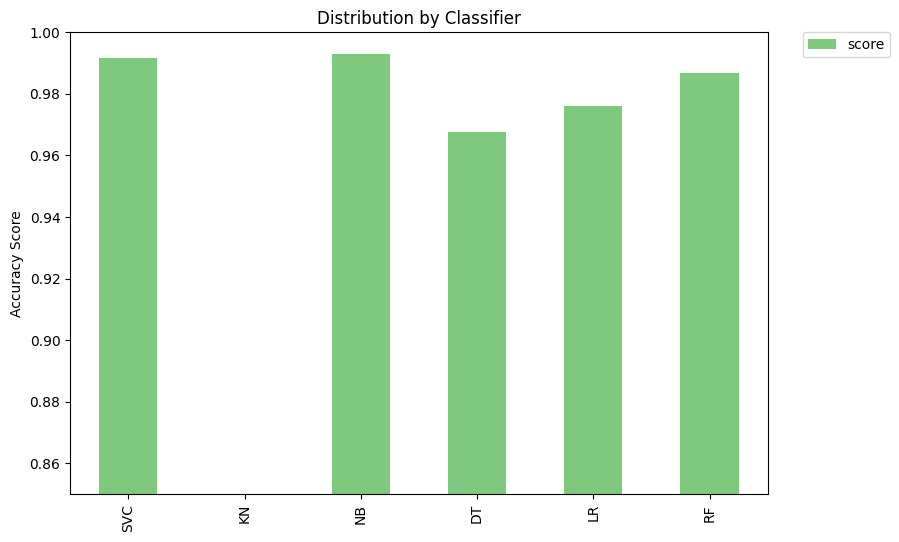

In [98]:
predictions.plot(kind='bar', ylim=(0.85,1.0), figsize=(9,6), align='center', colormap="Accent")
plt.xticks(np.arange(6), predictions.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [101]:
def find(p):
  if p == 1:
    print("Message is SPAM")
  else:
    print("Message is NOT SPAM")

text = ["Free tones Hope you enjoyed your new content"]
integers = vectorizer.transform(text)
p = mnb.predict(integers)[0]
find(p)

Message is SPAM


Saving an Model


In [102]:
import joblib

joblib.dump(mnb, 'best.pkl')
print("Best Mode is an Naive Bayes")

Best Mode is an Naive Bayes


In [103]:
best = joblib.load('best.pkl')
best

MultinomialNB(alpha=0.2)

Testing our Model


In [104]:
def test_pre(text):
  text = process_text_data(text)
  text = text_process(text)
  text = text.split("\n")
  print(text)
  return text

text1 = "hi how are you this msg is regarding to your job application"
text2 = "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
text3 = "Had your contract mobile 11 Mnths? Latest Motorola Now"
text4 = "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030"

text1 = test_pre(text1)
text2 = test_pre(text2)
text3 = test_pre(text3)
text4 = test_pre(text4)

integers1 = vectorizer.transform(text1)
integers2 = vectorizer.transform(text2)
integers3 = vectorizer.transform(text3)
integers4 = vectorizer.transform(text4)

['hi msg regarding job application']
['go jurong point crazy available bugis great world la buffet cine got amore wat']
['contract mobile mnths latest motorola']
['mobile months entitled update latest colour mobiles camera free call mobile update co free']


In [105]:
p1 = best.predict(integers1)[0]
p2 = best.predict(integers2)[0]
p3 = best.predict(integers3)[0]
p4 = best.predict(integers4)[0]

find(p1)
find(p2)
find(p3)
find(p4)
print(p1)
print(p2)
print(p3)
print(p4)

Message is NOT SPAM
Message is NOT SPAM
Message is SPAM
Message is SPAM
0
0
1
1
